In [26]:
# ---------------------------
# 1. Imports & Environment Setup
# ---------------------------

import requests
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
import time
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

# nicer plots
plt.style.use("default")
sns.set()

# Load API key from .env
load_dotenv()
API_KEY = os.getenv("TMDB_API_KEY")

BASE_URL = "https://api.themoviedb.org/3"

In [27]:
# ---------------------------
# 2. TMDB API Helper Functions
# ---------------------------

def get_movies_from_page(page: int) -> dict:
    """
    Get one page of movies from TMDB discover endpoint,
    sorted by vote_count (most voted first).
    """
    url = f"{BASE_URL}/discover/movie"
    params = {
        "api_key": API_KEY,
        "sort_by": "vote_count.desc",
        "page": page,
        "include_adult": False,
    }
    return requests.get(url, params=params).json()


def get_movie_details(movie_id: int) -> dict:
    """
    Get detailed metadata for a single movie.
    """
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()


def get_movie_credits(movie_id: int) -> dict:
    """
    Get cast & crew for a single movie.
    """
    url = f"{BASE_URL}/movie/{movie_id}/credits"
    params = {"api_key": API_KEY}
    return requests.get(url, params=params).json()


In [28]:
# ---------------------------
# 3. Scrape TMDB Movie Data
# ---------------------------

movies = []

PAGES_TO_SCRAPE = 10  # you can increase to 20–30 if you want more data

for page in tqdm(range(1, PAGES_TO_SCRAPE + 1), desc="Scraping pages"):
    page_data = get_movies_from_page(page)
    if "results" not in page_data:
        continue

    for movie in page_data["results"]:
        movie_id = movie["id"]

        details = get_movie_details(movie_id)
        credits = get_movie_credits(movie_id)
        time.sleep(0.15)  # polite pause to not hammer API

        record = {
            "id": movie_id,
            "title": details.get("title"),
            "release_date": details.get("release_date"),
            "release_year": int(details.get("release_date", "0000")[:4]) 
                              if details.get("release_date") else None,
            "budget": details.get("budget"),
            "revenue": details.get("revenue"),
            "runtime": details.get("runtime"),
            "popularity": details.get("popularity"),
            "vote_average": details.get("vote_average"),
            "vote_count": details.get("vote_count"),
            "genre_ids": [g["id"] for g in details.get("genres", [])],
            "production_companies": len(details.get("production_companies", [])),
            "cast_size": len(credits.get("cast", [])),
        }

        movies.append(record)

df = pd.DataFrame(movies)
df.head()

Scraping pages: 100%|██████████████████████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.60s/it]


,id,title,release_date,release_year,budget,revenue,runtime,popularity,vote_average,vote_count,genre_ids,production_companies,cast_size
0,157336,Interstellar,2014-11-05,2014,165000000,746606706,169,35.1733,8.462,38242,"[12, 18, 878]",3,34
1,27205,Inception,2010-07-15,2010,160000000,839030630,148,23.4385,8.370,38224,"[28, 878, 12]",3,52
2,155,The Dark Knight,2008-07-16,2008,185000000,1004558444,152,21.5716,8.524,34703,"[18, 28, 80, 53]",4,138
3,24428,The Avengers,2012-04-25,2012,220000000,1518815515,143,40.8323,7.852,33977,"[878, 28, 12]",1,113
4,19995,Avatar,2009-12-15,2009,237000000,2923706026,162,23.2365,7.593,32813,"[28, 12, 14, 878]",4,65


In [29]:
# ---------------------------
# 4. Basic Cleaning & Feature Engineering
# ---------------------------

# Drop rows missing key target-related fields
df = df.dropna(subset=["vote_average", "vote_count", "release_year"])

# Ensure genre_ids is always a list
df["genre_ids"] = df["genre_ids"].apply(lambda x: x if isinstance(x, list) else [])

# Movie age (relative to 2025; you can adjust the current year)
CURRENT_YEAR = 2025
df["movie_age"] = CURRENT_YEAR - df["release_year"]

df[["title", "release_year", "vote_average", "vote_count", "movie_age"]].head()


,title,release_year,vote_average,vote_count,movie_age
0,Interstellar,2014,8.462,38242,11
1,Inception,2010,8.370,38224,15
2,The Dark Knight,2008,8.524,34703,17
3,The Avengers,2012,7.852,33977,13
4,Avatar,2009,7.593,32813,16


In [30]:
# ---------------------------
# 5. One-Hot Encode Genres
# ---------------------------

# Collect all unique genre IDs across the dataset
all_genre_ids = sorted({gid for lst in df["genre_ids"] for gid in lst})

all_genre_ids

[12,
 14,
 16,
 18,
 27,
 28,
 35,
 36,
 37,
 53,
 80,
 878,
 9648,
 10402,
 10749,
 10751,
 10752]

In [32]:
# Create one-hot columns genre_<id>
for gid in all_genre_ids:
    df[f"genre_{gid}"] = df["genre_ids"].apply(lambda lst: int(gid in lst))

# quick check
[c for c in df.columns if c.startswith("genre_")][:10], len([c for c in df.columns if c.startswith("genre_")])

(['genre_ids',
  'genre_12',
  'genre_14',
  'genre_16',
  'genre_18',
  'genre_27',
  'genre_28',
  'genre_35',
  'genre_36',
  'genre_37'],
 18)

In [33]:
# ---------------------------
# 6. Map Genre IDs -> Names and Rename Columns
# ---------------------------

# Fetch TMDB official genre list
genre_url = f"https://api.themoviedb.org/3/genre/movie/list?api_key={API_KEY}"
genre_map_raw = requests.get(genre_url).json().get("genres", [])

genre_id_to_name = {g["id"]: g["name"] for g in genre_map_raw}
genre_id_to_name


{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

In [34]:
# Build rename mapping for only the IDs that appear in our data AND TMDB's genre list
rename_map = {}
for gid in all_genre_ids:
    old_col = f"genre_{gid}"
    if gid in genre_id_to_name:
        rename_map[old_col] = genre_id_to_name[gid]

rename_map

{'genre_12': 'Adventure',
 'genre_14': 'Fantasy',
 'genre_16': 'Animation',
 'genre_18': 'Drama',
 'genre_27': 'Horror',
 'genre_28': 'Action',
 'genre_35': 'Comedy',
 'genre_36': 'History',
 'genre_37': 'Western',
 'genre_53': 'Thriller',
 'genre_80': 'Crime',
 'genre_878': 'Science Fiction',
 'genre_9648': 'Mystery',
 'genre_10402': 'Music',
 'genre_10749': 'Romance',
 'genre_10751': 'Family',
 'genre_10752': 'War'}

In [35]:
# Apply rename to df
df = df.rename(columns=rename_map)

# Final list of genre columns with readable names
genre_columns = list(rename_map.values())
genre_columns

['Adventure',
 'Fantasy',
 'Animation',
 'Drama',
 'Horror',
 'Action',
 'Comedy',
 'History',
 'Western',
 'Thriller',
 'Crime',
 'Science Fiction',
 'Mystery',
 'Music',
 'Romance',
 'Family',
 'War']

In [36]:
# Check that genre columns look sane
df[genre_columns].head()

,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Music,Romance,Family,War
0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [37]:
# ---------------------------
# 7. Define Binary "Timeless" Label
# ---------------------------

# Threshold definition:
# Timeless if high rating AND lots of votes
# you can tweak thresholds, but 8.0 & 20,000 is reasonable
df["timeless"] = df.apply(
    lambda row: 1 if (row["vote_average"] >= 8.0 and row["vote_count"] >= 20000) else 0,
    axis=1
)

df["timeless"].value_counts()

timeless
0    174
1     26
Name: count, dtype: int64

In [38]:
# ---------------------------
# 8. Build Feature Matrix and Target
# ---------------------------

numeric_features = [
    "budget",
    "revenue",
    "runtime",
    "popularity",
    "movie_age",
    "cast_size",
    "production_companies",
]

feature_columns = numeric_features + genre_columns

X = df[feature_columns].fillna(0)
y = df["timeless"]

X.shape, y.shape

((200, 24), (200,))

In [39]:
# ---------------------------
# 9. Train/Test Split and Scaling
# ---------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()

# Work on copies so we don't overwrite original X_train/X_test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

X_train_scaled.shape, X_test_scaled.shape


((150, 24), (50, 24))

In [40]:
# ---------------------------
# 10. Train Logistic Regression & KNN Models
# ---------------------------

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("Logistic Regression Performance")
print("  Accuracy :", accuracy_score(y_test, y_pred_log))
print("  Precision:", precision_score(y_test, y_pred_log, zero_division=0))
print("  Recall   :", recall_score(y_test, y_pred_log, zero_division=0))

print("\nKNN Performance")
print("  Accuracy :", accuracy_score(y_test, y_pred_knn))
print("  Precision:", precision_score(y_test, y_pred_knn, zero_division=0))
print("  Recall   :", recall_score(y_test, y_pred_knn, zero_division=0))

Logistic Regression Performance
  Accuracy : 0.88
  Precision: 0.5
  Recall   : 0.3333333333333333

KNN Performance
  Accuracy : 0.88
  Precision: 0.0
  Recall   : 0.0


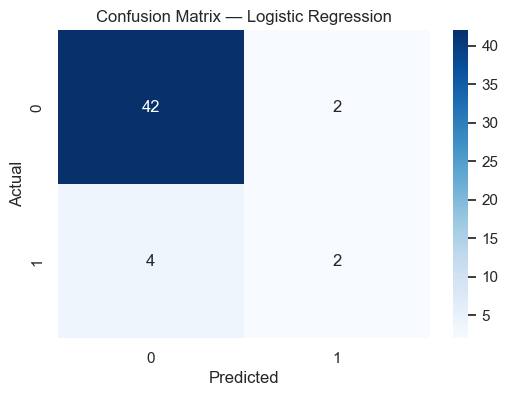


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        44
           1       0.50      0.33      0.40         6

    accuracy                           0.88        50
   macro avg       0.71      0.64      0.67        50
weighted avg       0.86      0.88      0.87        50



In [41]:
# ---------------------------
# 11. Confusion Matrix for Logistic Regression
# ---------------------------

cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, zero_division=0))

In [42]:
# ---------------------------
# 12. Misclassified Samples (for Assignment)
# ---------------------------

results = X_test_scaled.copy()
results = pd.DataFrame(results, index=X_test.index, columns=feature_columns)

results["actual"] = y_test
results["predicted"] = y_pred_log

# Bring back some human-readable columns
results["title"] = df.loc[results.index, "title"]
results["vote_average"] = df.loc[results.index, "vote_average"]
results["vote_count"] = df.loc[results.index, "vote_count"]
results["movie_age"] = df.loc[results.index, "movie_age"]

misclassified = results[results["actual"] != results["predicted"]]

# Show 5 misclassified examples
misclassified.head(5)

,budget,revenue,runtime,popularity,movie_age,cast_size,production_companies,Adventure,Fantasy,Animation,...,Mystery,Music,Romance,Family,War,actual,predicted,title,vote_average,vote_count
57,0.666198,0.338943,-1.079413,1.670811,8,0.401312,-1.147236,1,0,1,...,0,1,0,1,0,1,0,Coco,8.201,20420
38,-1.034084,-0.736080,-0.179675,0.097064,30,-0.306886,-0.007598,0,0,0,...,1,0,0,0,0,1,0,Se7en,8.400,22288
14,-0.231838,-0.519773,1.374418,-0.134123,13,1.965249,-0.577417,0,0,0,...,0,0,0,0,0,1,0,Django Unchained,8.185,27244
4,1.408575,4.991430,1.251727,1.747457,16,-0.129836,0.562222,1,1,0,...,0,0,0,0,0,0,1,Avatar,7.593,32813
9,-1.129874,-1.395593,0.433783,2.078229,31,-0.277377,-1.147236,0,0,0,...,0,0,0,0,0,1,0,The Shawshank Redemption,8.711,29218


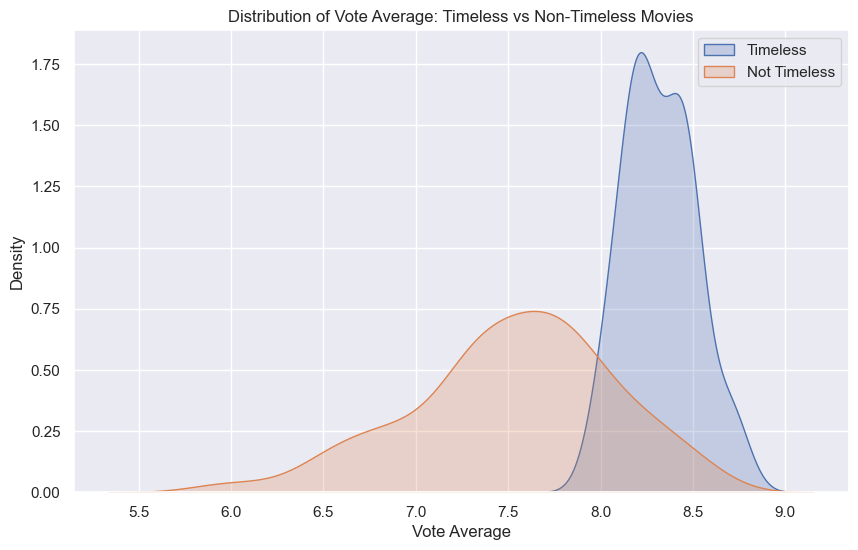

In [43]:
# ---------------------------
# 13. Viz 1 — Vote Average Distribution
# ---------------------------

plt.figure(figsize=(10,6))

sns.kdeplot(df[df["timeless"] == 1]["vote_average"], label="Timeless", fill=True)
sns.kdeplot(df[df["timeless"] == 0]["vote_average"], label="Not Timeless", fill=True)

plt.title("Distribution of Vote Average: Timeless vs Non-Timeless Movies")
plt.xlabel("Vote Average")
plt.ylabel("Density")
plt.legend()
plt.show()

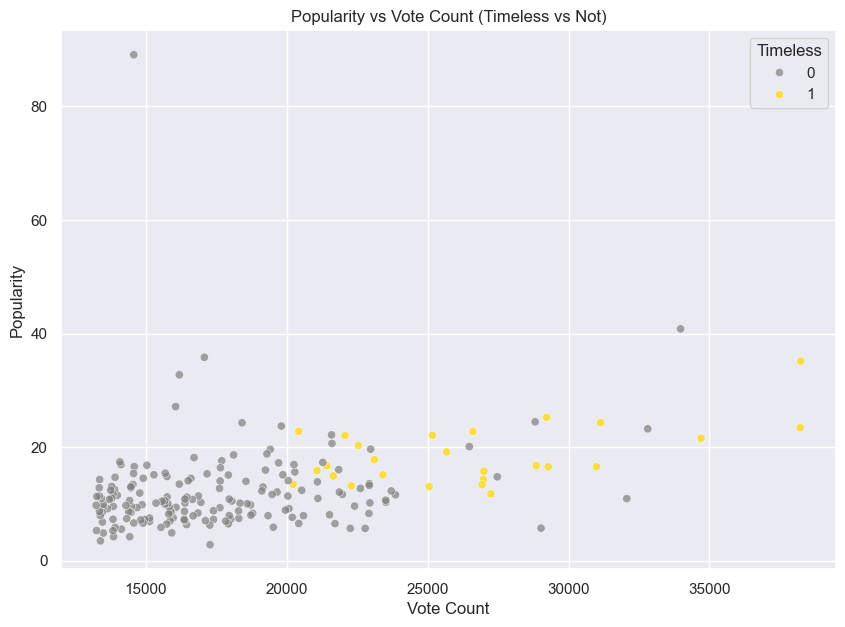

In [44]:
# ---------------------------
# 14. Viz 2 — Popularity vs Vote Count
# ---------------------------

plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df,
    x="vote_count",
    y="popularity",
    hue="timeless",
    palette={0: "gray", 1: "gold"},
    alpha=0.7
)

plt.title("Popularity vs Vote Count (Timeless vs Not)")
plt.xlabel("Vote Count")
plt.ylabel("Popularity")
plt.legend(title="Timeless")
plt.show()

In [45]:
# ---------------------------
# 15. Viz 3 — Most Common Genres in Timeless Movies
# ---------------------------

timeless_movies = df[df["timeless"] == 1]

genre_counts = timeless_movies[genre_columns].sum().sort_values(ascending=False)
genre_counts

Adventure          13
Drama              12
Action             10
Crime               7
Thriller            7
Science Fiction     7
Fantasy             5
Comedy              4
Mystery             2
Music               1
Romance             1
Animation           1
Western             1
Family              1
War                 1
History             0
Horror              0
dtype: int64

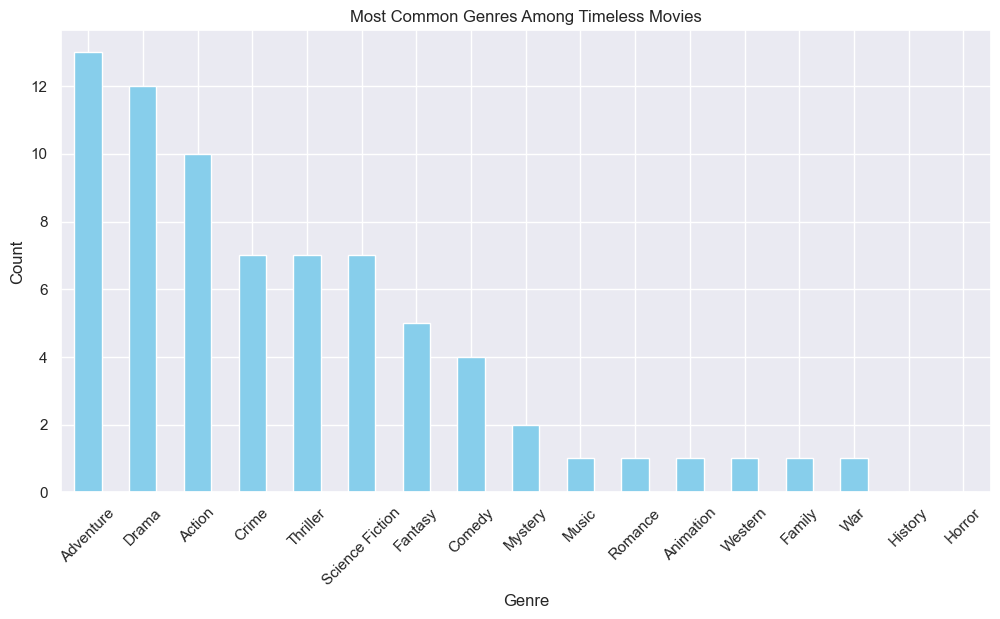

In [46]:
plt.figure(figsize=(12,6))
genre_counts.plot(kind="bar", color="skyblue")
plt.title("Most Common Genres Among Timeless Movies")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

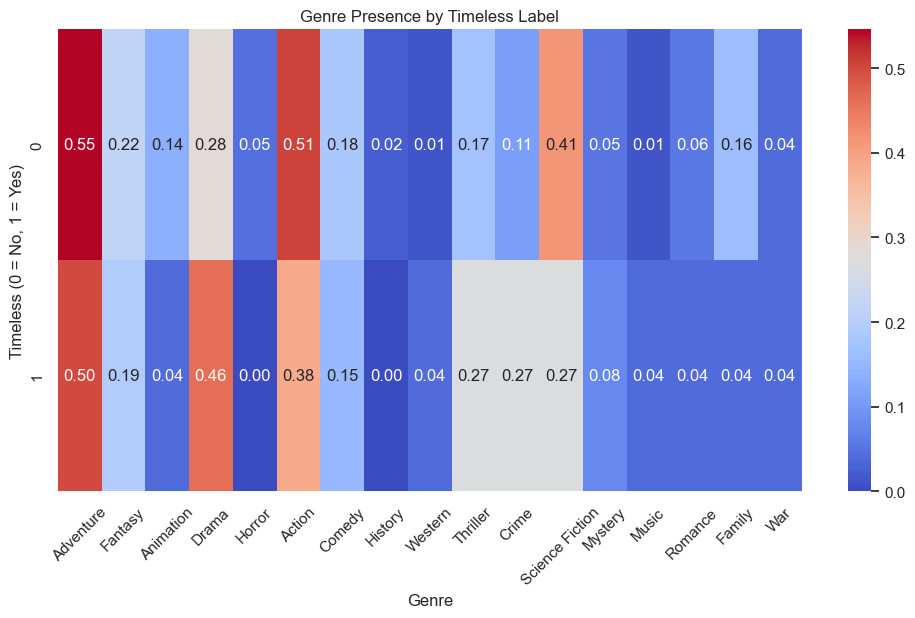

In [47]:
# ---------------------------
# 16. Viz 4 — Genre Presence Heatmap
# ---------------------------

genre_df = df[genre_columns + ["timeless"]]
genre_avg = genre_df.groupby("timeless").mean()

plt.figure(figsize=(12,6))
sns.heatmap(genre_avg, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Genre Presence by Timeless Label")
plt.xlabel("Genre")
plt.ylabel("Timeless (0 = No, 1 = Yes)")
plt.xticks(rotation=45)
plt.show()

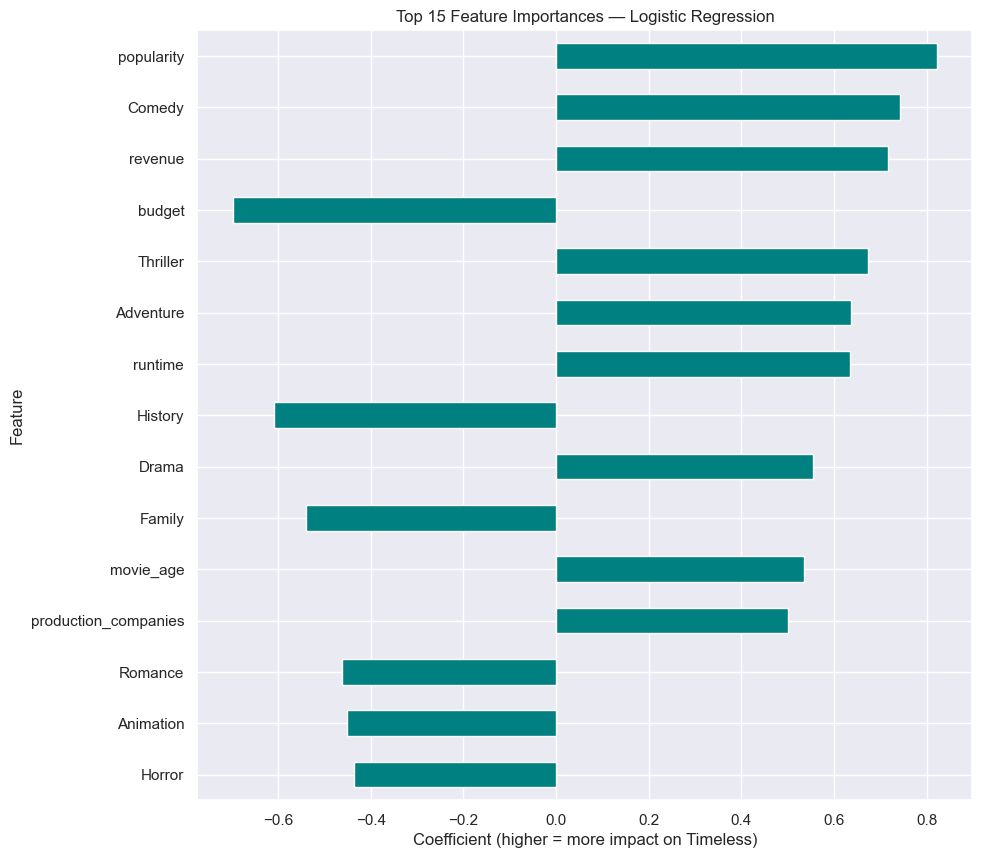

In [48]:
# ---------------------------
# 17. Viz 5 — Feature Importance (Logistic Regression)
# ---------------------------

coef_series = pd.Series(
    logreg.coef_[0],
    index=feature_columns
).sort_values(key=lambda s: s.abs(), ascending=False)

plt.figure(figsize=(10,10))
coef_series.head(15).plot(kind="barh", color="teal")
plt.title("Top 15 Feature Importances — Logistic Regression")
plt.xlabel("Coefficient (higher = more impact on Timeless)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [49]:
# ---------------------------
# 18. Save Final Dataset
# ---------------------------

df.to_csv("tmdb_timeless_movies.csv", index=False)
"Saved tmdb_timeless_movies.csv"

'Saved tmdb_timeless_movies.csv'